In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
import matplotlib
import japanize_matplotlib
import shap

/Users/itsukikuwahara/Desktop/codes/research/pref_data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データの準備

In [2]:
# 全ての年度のデータを結合する関数
def concat_df(df_dict):
    df = pd.concat([df_dict[key] for key in df_dict.keys()])
    return df

In [3]:
# object_df_dictをpickleファイルから読み込む
with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/object_df_dict.pkl', 'rb') as f:
    object_df_dict = pickle.load(f)
    
with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/df_young.pkl', 'rb') as f:
    df_young = pickle.load(f)

df_dict = {}

for key in object_df_dict.keys():
    year = str(key) + '年度'
    
    # 若年人口のデータフレームを結合
    temp = df_young[df_young["調査年"]==year][["地域", "若年人口"]]
    merged = pd.merge(object_df_dict[key], temp, on="地域")
    
    # 若年人口割合を算出
    merged["若年人口割合"] = merged["若年人口"] / merged["A1101_総人口【人】"]
    df_dict[key] = merged

# 全ての年度のデータを１つのデータフレームに結合    
df = concat_df(df_dict)

# 東京を外れ値として除外
# df.drop(df[df["地域"]=="東京都"].index, inplace=True)

## 変化率を算出

In [4]:
# 増減率を計算した新たなデータフレームを作成し、辞書に保存
def calc_change_rate(dictionary):
    df_change_rate_dict = {}
    year_list = list(dictionary.keys())
    
    for i in range(len(year_list)-1):
        # 対象年と１つ前の年度を取得、辞書のキーを作成
        prev_year = year_list[i]
        year = year_list[i+1]
        year2year = str(prev_year) + "_" + str(year)

        # 対象年と１つ前の年度のデータフレームを取得        
        prev_year_df = dictionary[year_list[i]].iloc[:, 2:]
        year_df = dictionary[year_list[i+1]].iloc[:, 2:]
        area = dictionary[year_list[i]]["地域"]
        
        # 0で割るのを防ぐために全ての列に１を足す
        prev_year_df = prev_year_df + 1
        year_df = year_df + 1
        
        # 変化率を計算
        df_change_rate = (year_df - prev_year_df) / prev_year_df

        # 変化率を計算したデータフレームに地域と調査年を追加
        df_change_rate = pd.concat([area, df_change_rate], axis=1)
        df_change_rate_dict[year2year] = df_change_rate        
        
    return df_change_rate_dict

In [5]:
df_cr_rate = calc_change_rate(df_dict)
df_cr = concat_df(df_cr_rate)

## データの分割

In [6]:
# オリジナルデータ
y = df["若年人口割合"]
x = df.drop(["若年人口","若年人口割合","地域", "調査年"], axis=1)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
# 変化率データ
cr_y = df["若年人口割合"]
cr_x = df.drop(["若年人口","若年人口割合","地域", "調査年"], axis=1)

train_x_cr, test_x_cr, train_y_cr, test_y_cr = train_test_split(cr_x, cr_y, test_size=0.2, random_state=0)

## モデルの学習

In [8]:
# オリジナルデータ
model = lgb.LGBMRegressor()
model.fit(train_x, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48323
[LightGBM] [Info] Number of data points in the train set: 1278, number of used features: 209
[LightGBM] [Info] Start training from score 0.451852


LGBMRegressor()

In [9]:
# 変化率データ
model_cr = lgb.LGBMRegressor()
model_cr.fit(train_x_cr, train_y_cr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48323
[LightGBM] [Info] Number of data points in the train set: 1278, number of used features: 209
[LightGBM] [Info] Start training from score 0.451852


LGBMRegressor()

## モデルの評価

In [10]:
# オリジナルデータ
predict_y = model.predict(test_x)
mse = mean_squared_error(test_y, predict_y)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, predict_y)

print(f"mse : {mse}, rmse : {rmse}, r2 : {r2}")

mse : 6.443272979498403e-05, rmse : 0.008027000049519374, r2 : 0.982407504837721


In [11]:
# 変化率データ
predict_y_cr = model_cr.predict(test_x_cr)
mse_cr = mean_squared_error(test_y_cr, predict_y_cr)
rmse_cr = np.sqrt(mse_cr)
r2_cr = r2_score(test_y_cr, predict_y_cr)

print(f"mse : {mse_cr}, rmse : {rmse_cr}, r2 : {r2_cr}")

mse : 6.443272979498403e-05, rmse : 0.008027000049519374, r2 : 0.982407504837721


## 特徴量重要度を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

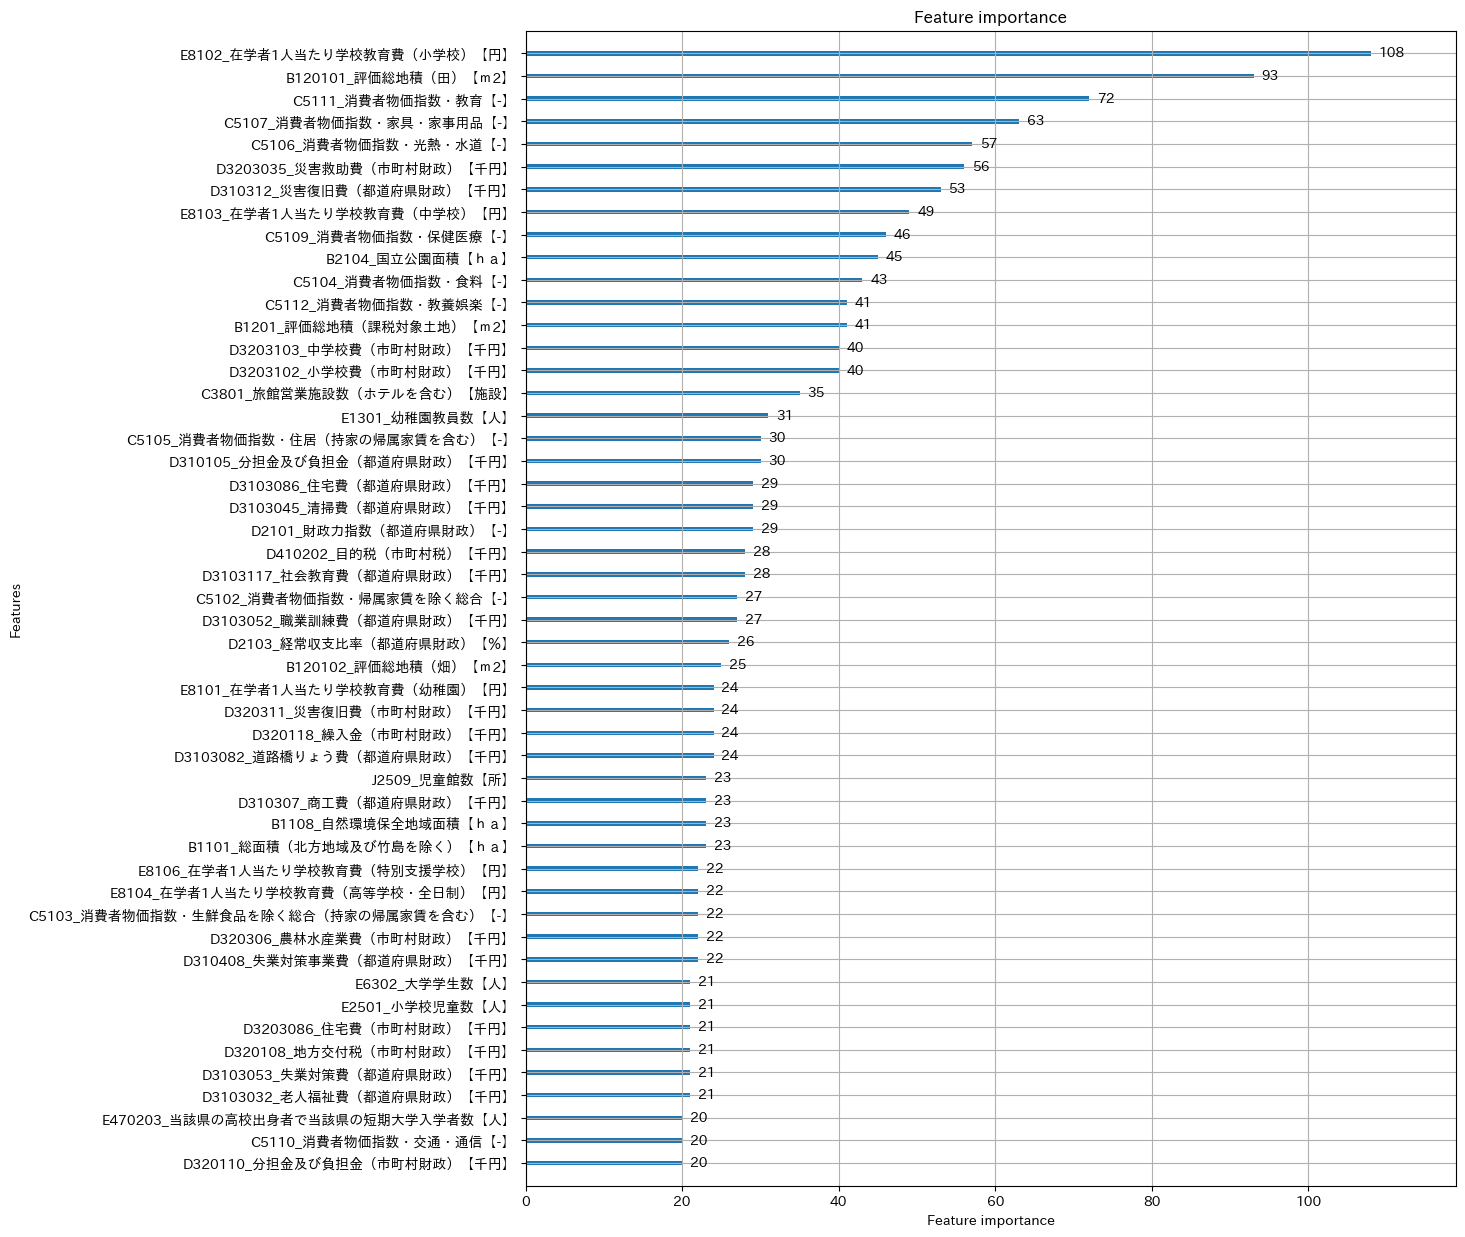

In [12]:
# オリジナルデータ
lgb.plot_importance(model, figsize=(12, 15), max_num_features=50)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

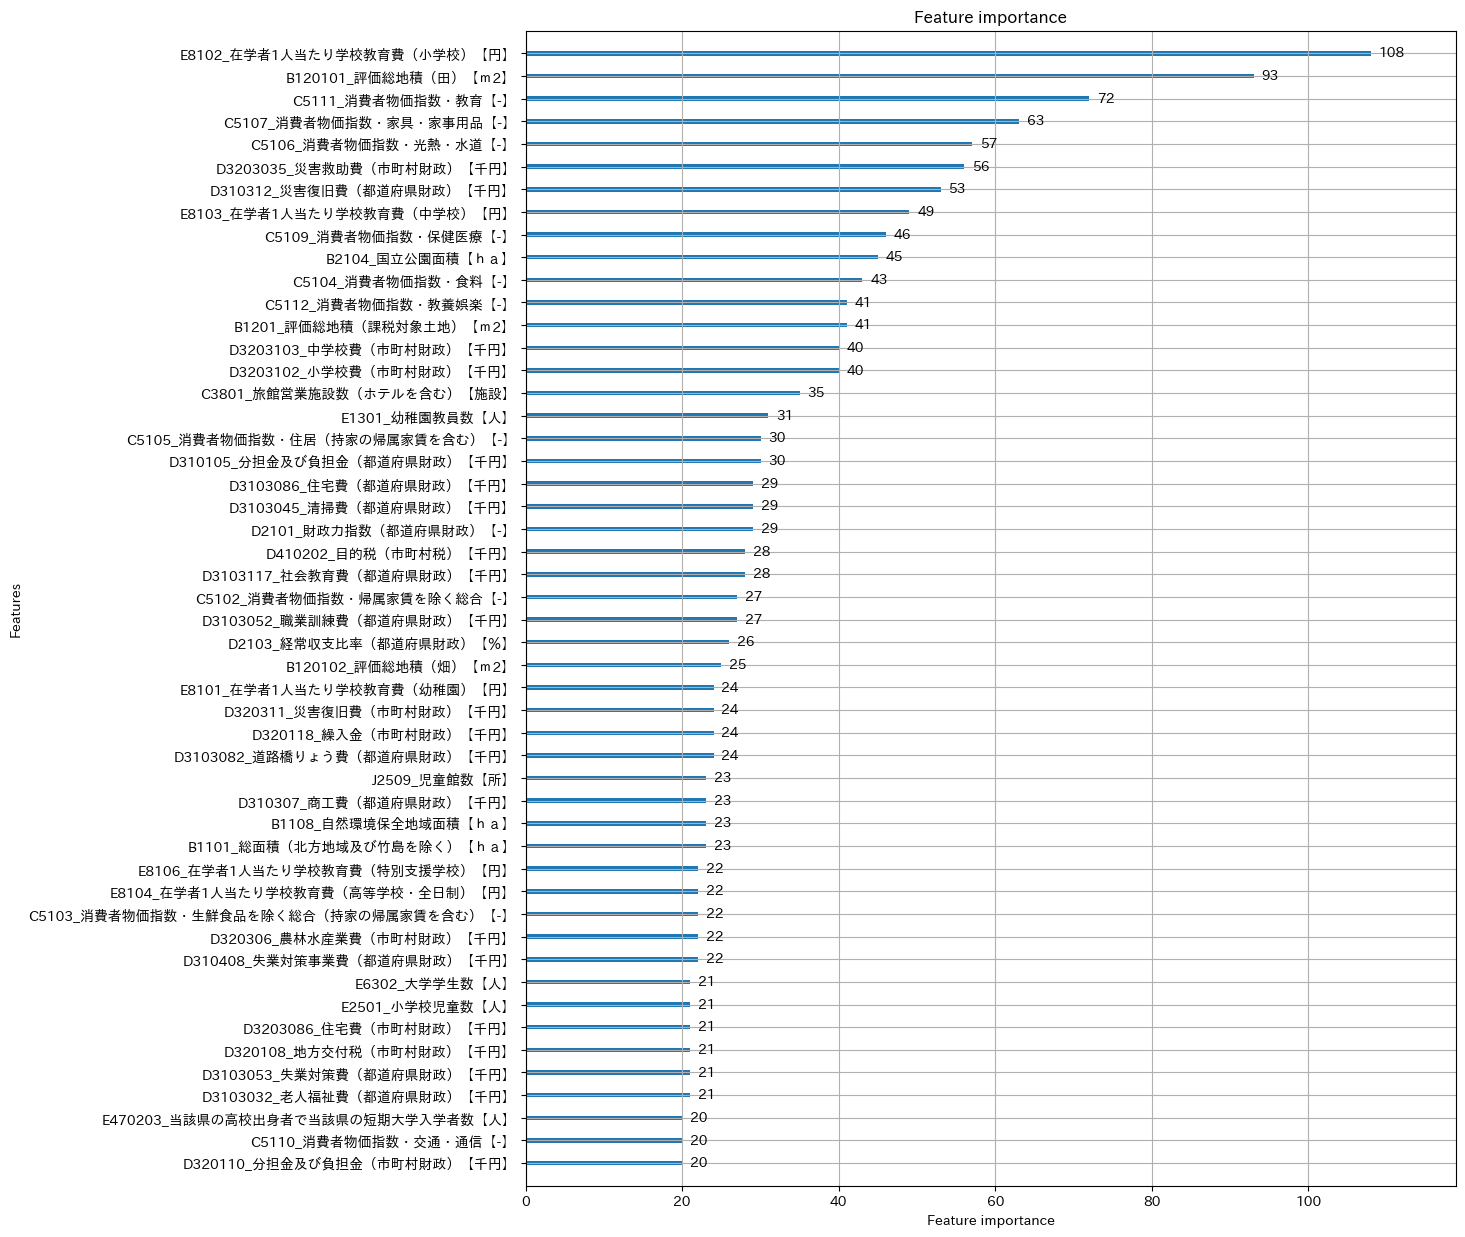

In [13]:
# 変化率データ
lgb.plot_importance(model_cr, figsize=(12, 15), max_num_features=50)

## SHAPを利用した重要度分析

In [14]:
# オリジナルデータ
explainer = shap.Explainer(model)
shap_values = explainer(test_x)

In [15]:
# 変化率データ
explainer_cr = shap.Explainer(model_cr)
shap_values_cr = explainer_cr(test_x_cr)

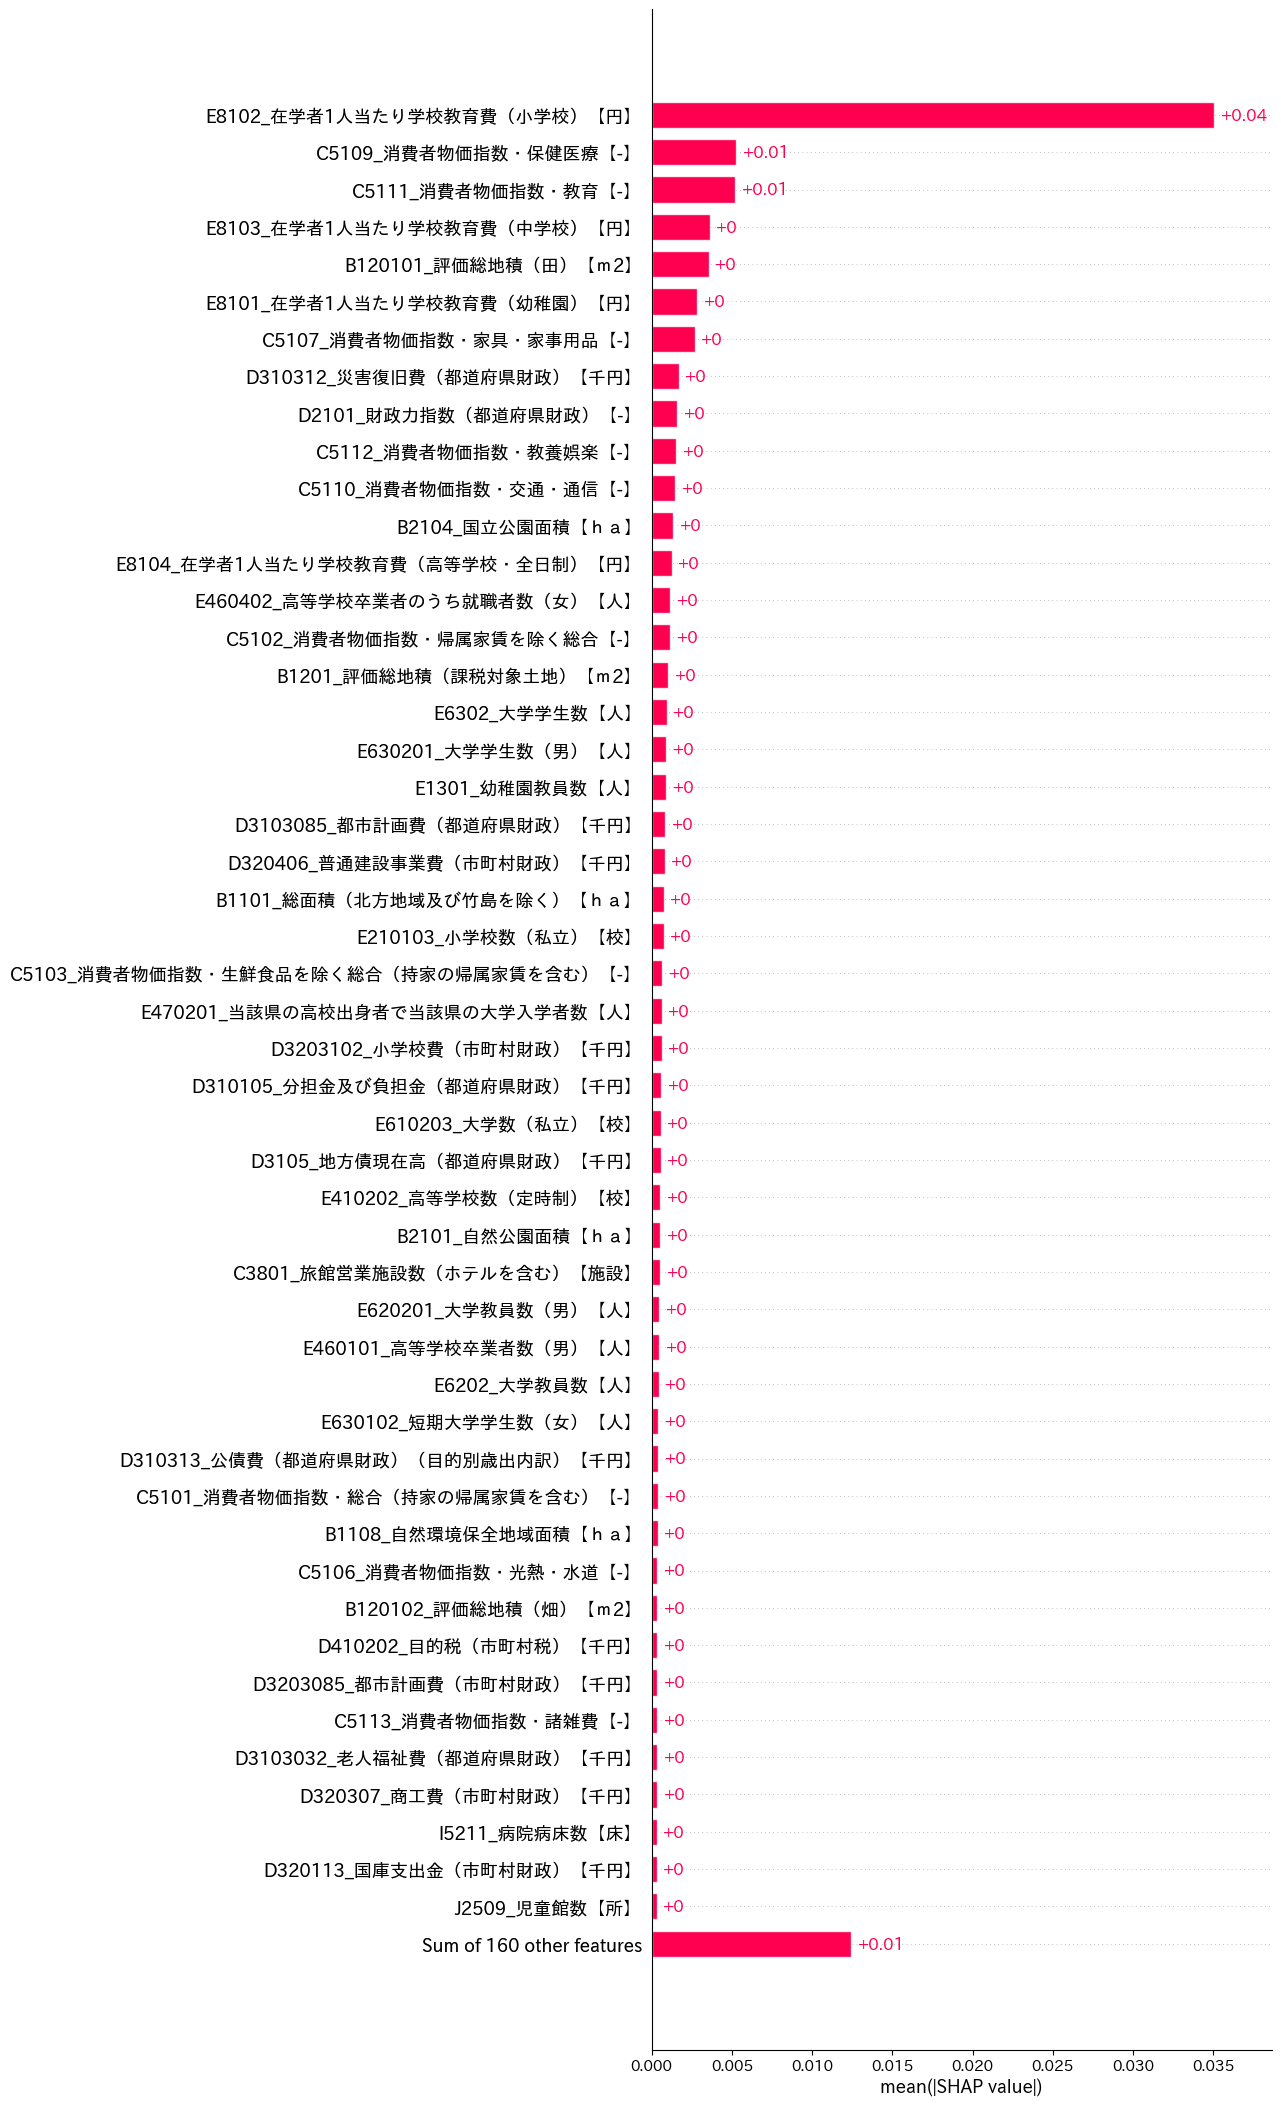

In [16]:
# オリジナルデータ
shap.plots.bar(shap_values, max_display=50)

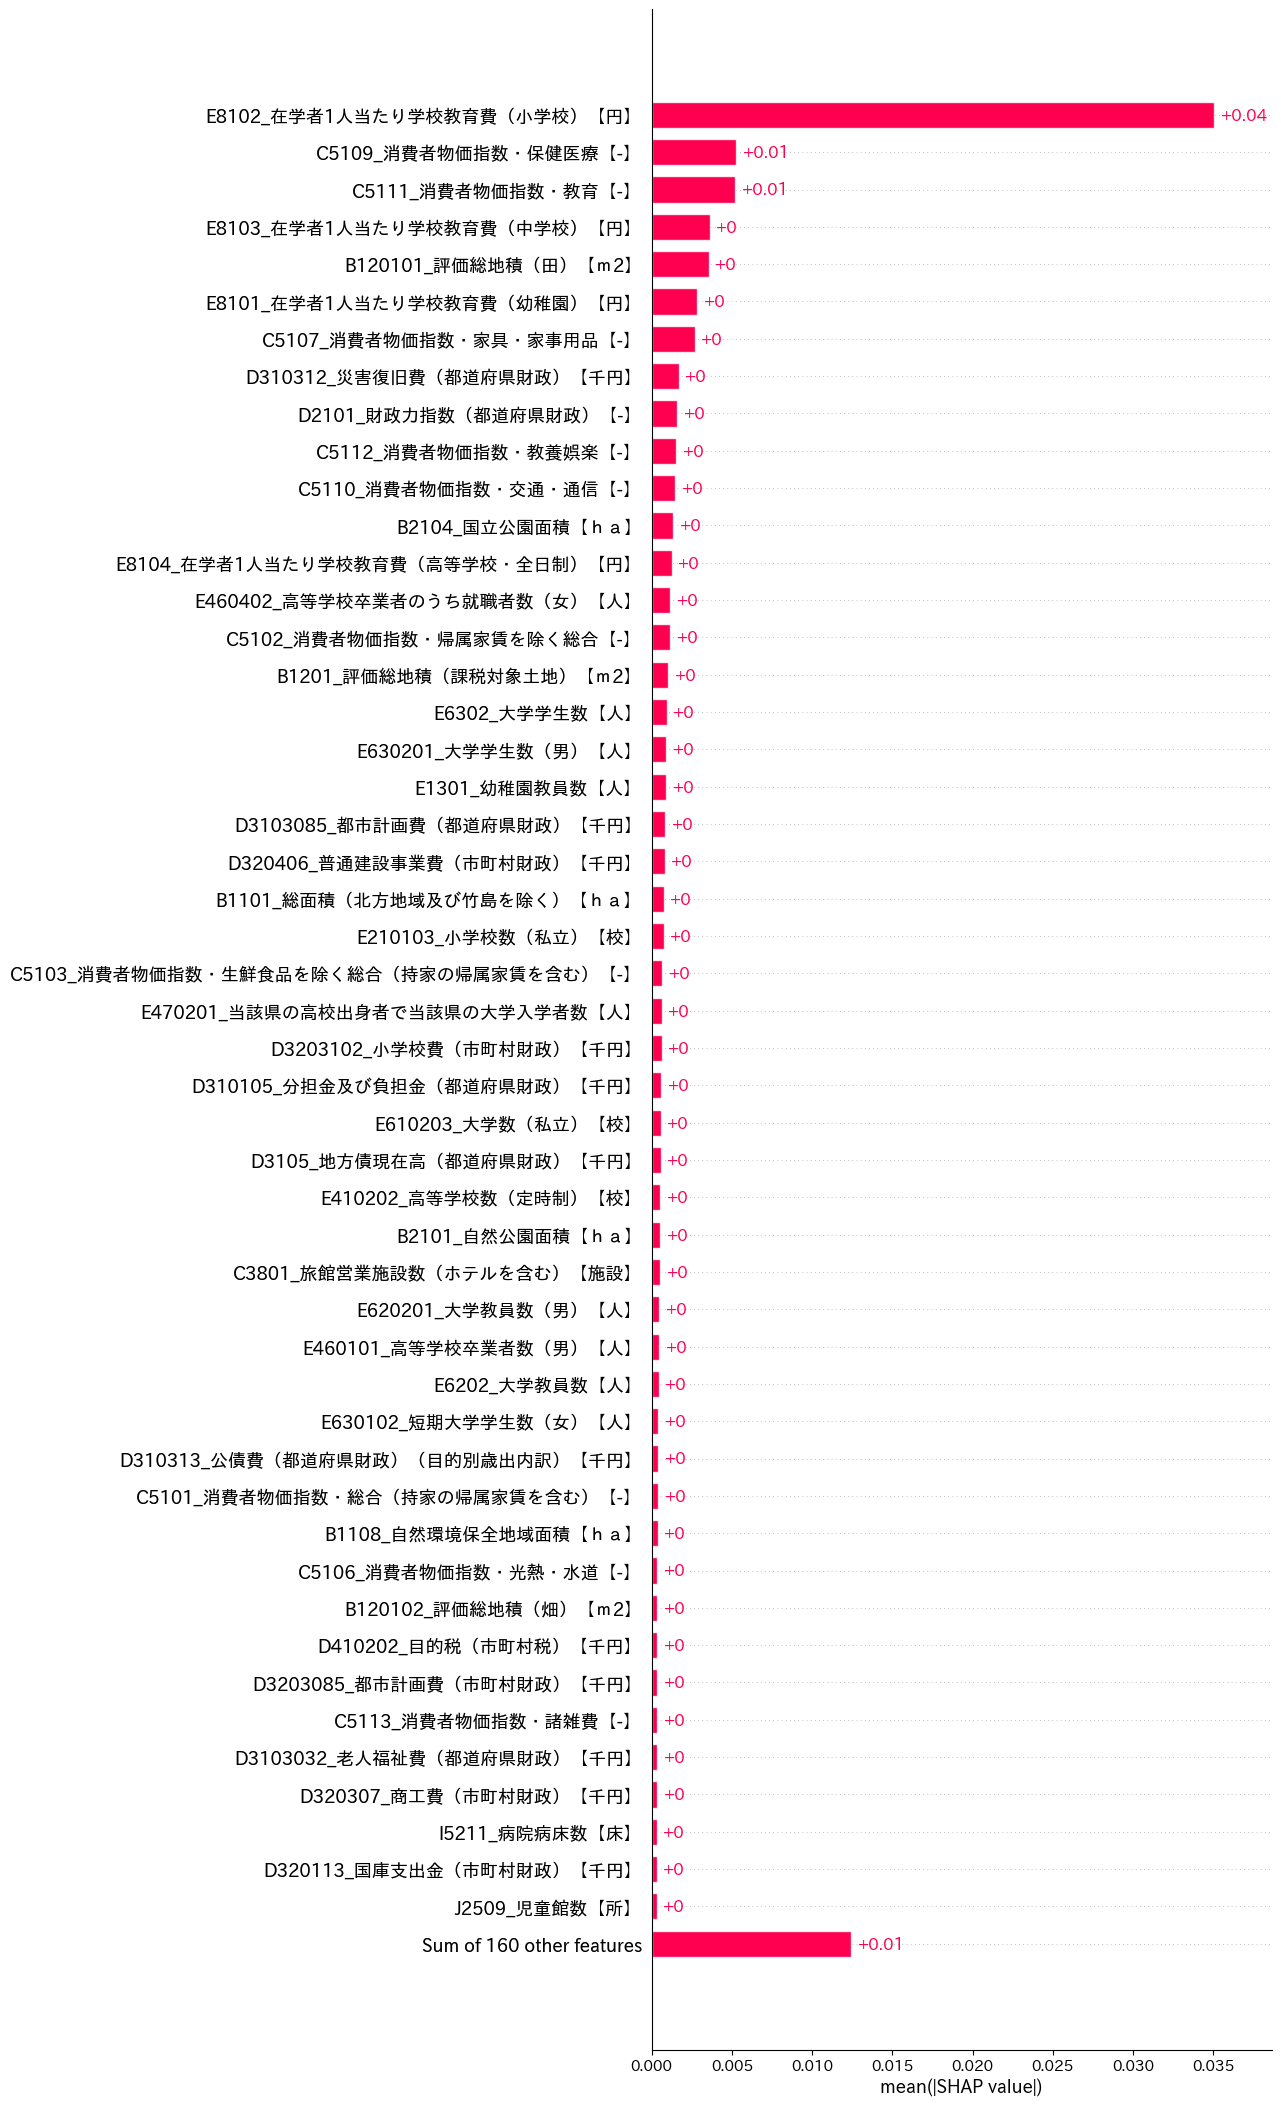

In [17]:
# 変化率データ
shap.plots.bar(shap_values_cr, max_display=50)

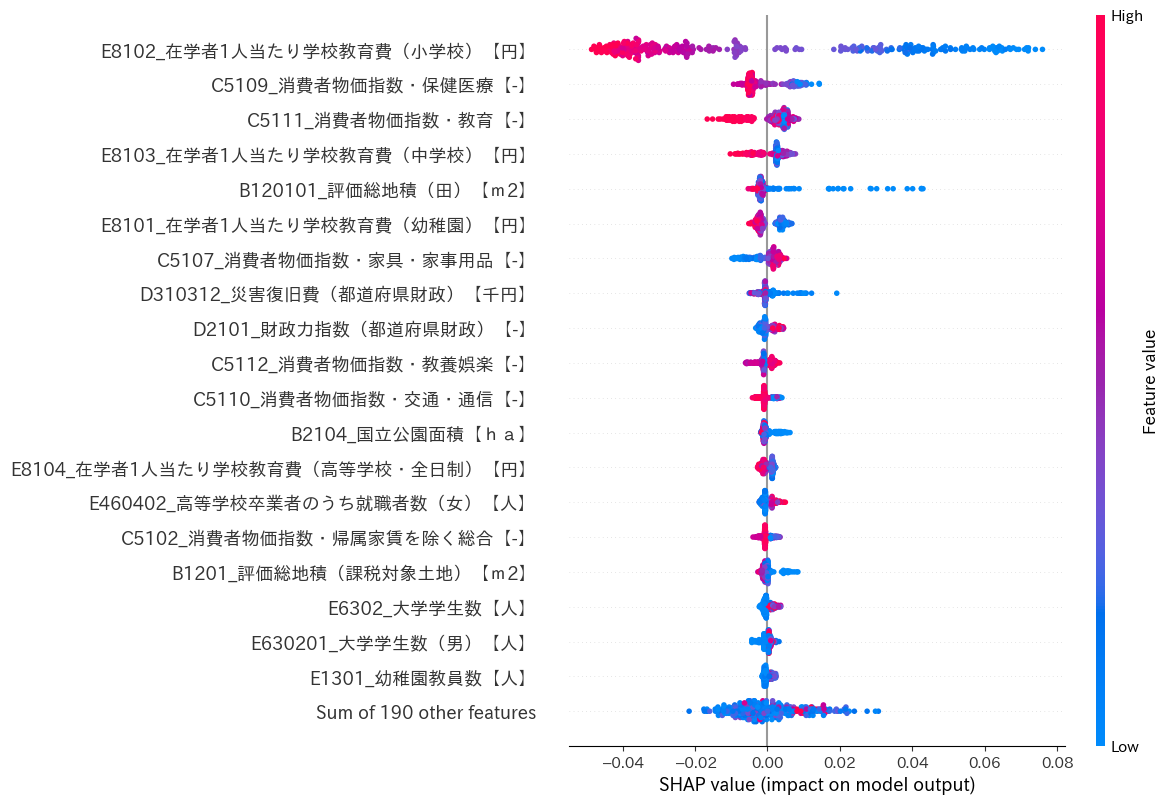

In [18]:
# オリジナルデータ
shap.plots.beeswarm(shap_values, max_display=20)

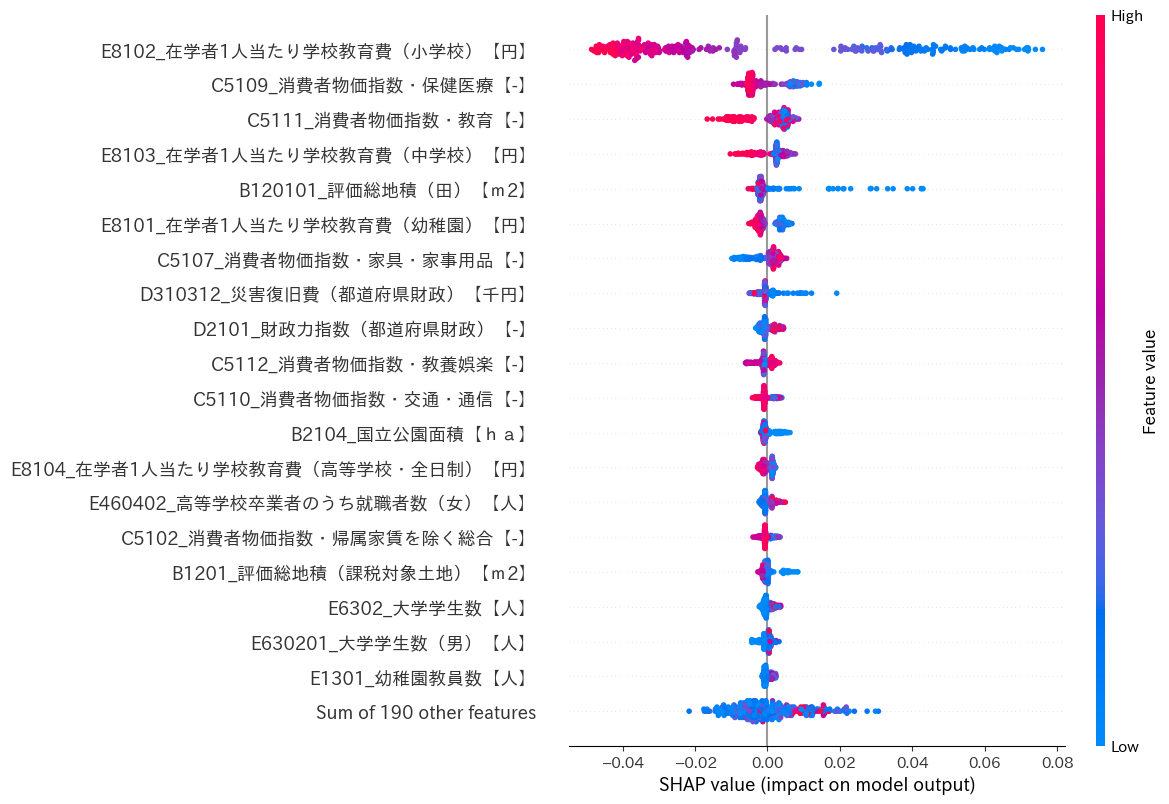

In [19]:
# 変化率データ
shap.plots.beeswarm(shap_values_cr, max_display=20)

In [20]:
#  SHAP値の絶対値の平均を算出し、上位50位の特徴量を取得
shap_values_abs = np.abs(shap_values.values).mean(axis=0)
shap_values_cr_abs = np.abs(shap_values_cr.values).mean(axis=0)

top_50_indices = np.argsort(shap_values_abs)[-50:][::-1]
top_50_indices_cr = np.argsort(shap_values_cr_abs)[-50:][::-1]

top_50 = test_x.columns[top_50_indices]
top_50_cr = test_x_cr.columns[top_50_indices_cr]

In [24]:
df.to_csv("/Users/itsukikuwahara/Desktop/codes/research/data/data_pref/df.csv", index=False)
df_cr.to_csv("/Users/itsukikuwahara/Desktop/codes/research/data/data_pref/df_cr.csv", index=False)

In [ ]:
# with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/top_50.pkl', 'wb') as f:
#     pickle.dump(top_50, f)

# with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/top_50_cr.pkl', 'wb') as f:
#     pickle.dump(top_50_cr, f)